# Quantum Fourier Transform Benchmark

In [1]:
low = 1
high = 27
samples = 10

In [2]:
import time
import random
import math

## PyQrack

In [3]:
%env QRACK_QUNITMULTI_DEVICES 1
from pyqrack import QrackSimulator, Pauli

def reverse_qrack(sim):
    start = 0
    end = sim.num_qubits() - 1
    while (start < end):
        sim.swap(start, end)
        start += 1
        end -= 1

env: QRACK_QUNITMULTI_DEVICES=1


### |0> initialization

In [4]:
def bench_qrack_0(n):
    sim = QrackSimulator(n)
    sim.set_reactive_separate(False)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack.
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_0_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack_0(n))

    qrack_0_results[n] = sum(width_results) / samples

print(qrack_0_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{1: 0.000184851000267372, 2: 6.79157996273716e-05, 3: 5.287690019031288e-05, 4: 5.631050007650629e-05, 5: 5.805119999422459e-05, 6: 5.528860001504654e-05, 7: 6.331920012598857e-05, 8: 6.002180034556659e-05, 9: 5.949469996266998e-05, 10: 6.600989981961903e-05, 11: 6.666130011581117e-05, 12: 6.477410006482387e-05, 13: 7.1328000012727e-05, 14: 7.561479997093556e-05, 15: 7.001640024100198e-05, 16: 7.5654099782696e-05, 17: 8.079789986368269e-05, 18: 8.21793999421061e-05, 19: 8.049339976423653e-05, 20: 8.574229959776858e-05, 21: 9.060129996214527e-05, 22: 8.54675994560239e-05, 23: 9.116330002143514e-05, 24: 9.601350011507747e-05, 25: 9.437349999643629e-05, 26: 9.66231998972944e-05, 27: 0.00010000149995903485}


### Random 1-qubit unitary initialization

In [5]:
def bench_qrack(n):
    sim = QrackSimulator(n)
    sim.set_reactive_separate(False)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack,
    # so we give it a realistic case instead.
    for i in range(n):
        # Initialize with uniformly random single qubit gates, across full width.
        sim.u(i, random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi))
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack(n))

    qrack_results[n] = sum(width_results) / samples

print(qrack_results)

{1: 3.9211399780469947e-05, 2: 7.748690004518721e-05, 3: 0.00016848399973241613, 4: 0.0001624390000870335, 5: 0.0002826697998898453, 6: 0.00032649400000082094, 7: 0.0004469361001611105, 8: 0.0004586245999234961, 9: 0.0006417029999283841, 10: 0.0008658401999127818, 11: 0.0014087982001001365, 12: 0.0018250097002237454, 13: 0.0023399173998768672, 14: 0.002558129399767495, 15: 0.003039582000019436, 16: 0.0034706919997915973, 17: 0.003956374299923482, 18: 0.004455362200133095, 19: 0.005479153899796074, 20: 0.007088591499996255, 21: 0.010102406199439428, 22: 0.01607552890000079, 23: 0.028177917899665773, 24: 0.05080444829945918, 25: 0.0905077708997851, 26: 0.1753653078998468, 27: 0.3444114758996875}


### GHZ state initialization

In [6]:
def bench_qrack(n):
    sim = QrackSimulator(n)
    sim.set_reactive_separate(False)
    sim.h(0)
    for i in range(n - 1):
        sim.mcx([i], i + 1)
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_k_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack(n))

    qrack_k_results[n] = sum(width_results) / samples

print(qrack_k_results)

{1: 1.4618400382460094e-05, 2: 3.272300000389805e-05, 3: 0.0001396585998008959, 4: 0.00010055940019810805, 5: 0.00021409619985206517, 6: 0.00018937400018330662, 7: 0.00014487070020550164, 8: 0.00022793209991505136, 9: 0.0002935441996669397, 10: 0.0005107500997837633, 11: 0.0014623974002461182, 12: 0.0016412287001003278, 13: 0.002019133900284942, 14: 0.0024130797002726466, 15: 0.002495377800005372, 16: 0.002726257500216889, 17: 0.0028946975002327236, 18: 0.0035364346002097593, 19: 0.004281363600239274, 20: 0.008291691699560034, 21: 0.01496795689981809, 22: 0.02736225069984357, 23: 0.05291771979991609, 24: 0.10614347499995347, 25: 0.21766049920024672, 26: 0.4434376611998232, 27: 0.9152332912999555}


## FFTW ("Classical" DFT)

In [7]:
import pyfftw
import numpy as np

# See https://blog.hpc.qmul.ac.uk/pyfftw.html
pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(60)
total_time = 0

### |0> initialization

In [8]:
fftw_0_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.zeros_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1.
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.ifft(io_array, overwrite_input=True, threads = (16 if (n > 20) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_0_results[n] = sum(width_results) / samples

print(fftw_0_results)

{1: 4.0740700023889075e-05, 2: 4.779089995281538e-05, 3: 2.295649974257685e-05, 4: 2.5668899979791604e-05, 5: 5.2580100236809814e-05, 6: 2.7133199910167605e-05, 7: 9.902909987431485e-05, 8: 3.087160002905876e-05, 9: 2.593829995021224e-05, 10: 3.3095100116042885e-05, 11: 3.5795099938695786e-05, 12: 4.0661000275576954e-05, 13: 7.307749929168495e-05, 14: 0.00013245700010884321, 15: 0.00023410599987983005, 16: 0.00047412250023626257, 17: 0.0010723922001488972, 18: 0.0024228978998507957, 19: 0.008122417900085565, 20: 0.016566360499382426, 21: 0.01815400990017224, 22: 0.053501792300085074, 23: 0.10551648069995281, 24: 0.20229848660037533, 25: 0.38549744909978473, 26: 0.8956314880002537, 27: 1.8286048759004188}


### Random 1-qubit unitary initialization

In [9]:
fftw_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.empty_aligned(2**n, dtype=np.complex64)
        
        # Use Qrack to initialize the test case!
        sim = QrackSimulator(n)
        for i in range(n):
            # Initialize with uniformly random single qubit gates, across full width.
            sim.u(i, random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi))
        ket = sim.out_ket()
        del sim
        for i in range(2**n):
            io_array[i] = ket[i]
        del ket
        
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.ifft(io_array, overwrite_input=True, threads = (16 if (n > 20) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_results[n] = sum(width_results) / samples

print(fftw_results)

{1: 3.001020031661028e-05, 2: 2.8649100022448694e-05, 3: 3.0967200109444094e-05, 4: 3.1937400126480495e-05, 5: 3.09982997350744e-05, 6: 3.285019975010073e-05, 7: 3.523080013110302e-05, 8: 3.724029993463773e-05, 9: 3.7372599945229015e-05, 10: 4.030009968118975e-05, 11: 4.2102599945792465e-05, 12: 6.0908599880349354e-05, 13: 9.350960008305264e-05, 14: 0.0001510127000074135, 15: 0.00030082680004852593, 16: 0.0005484375002197339, 17: 0.0011004368998328573, 18: 0.0024550707001253615, 19: 0.008535921300244808, 20: 0.015958257599959325, 21: 0.015046743199673075, 22: 0.04544735490017047, 23: 0.09455617670009815, 24: 0.1951308395000524, 25: 0.37157032219984104, 26: 0.8894585232003009, 27: 1.9730739055999948}


### GHZ initialization

In [10]:
fftw_k_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.zeros_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1 / math.sqrt(2)
        io_array[2**n - 1] = 1 / math.sqrt(2)
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.ifft(io_array, overwrite_input=True, threads = (16 if (n > 20) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_k_results[n] = sum(width_results) / samples

print(fftw_k_results)

{1: 7.174389993451769e-05, 2: 9.390070044901222e-05, 3: 3.13920001644874e-05, 4: 1.9938199875468855e-05, 5: 1.8718400133366232e-05, 6: 1.9751199761230965e-05, 7: 1.991420012927847e-05, 8: 1.9847399744321593e-05, 9: 2.1322099746612368e-05, 10: 2.292549961566692e-05, 11: 2.6655899637262338e-05, 12: 3.7202000021352434e-05, 13: 5.680840040440671e-05, 14: 9.767430019564926e-05, 15: 0.0001894805003757938, 16: 0.0003948022998883971, 17: 0.0008425217005424201, 18: 0.001877795300242724, 19: 0.0071646026999587775, 20: 0.015440296199994919, 21: 0.013210435600012716, 22: 0.04662722280008893, 23: 0.09777244439992501, 24: 0.1950484887998755, 25: 0.37600211249991844, 26: 0.8763392510001722, 27: 1.7779119232001903}


## Qiskit Aer

In [11]:
from qiskit import QuantumCircuit
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator

def reverse_aer(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.swap(start, end)
        start += 1
        end -= 1

# Implementation of the Quantum Fourier Transform
def aer_qft(num_qubits, circ):
    # Quantum Fourier Transform
    for j in range(num_qubits):
        for k in range(j):
            circ.cp(math.pi/float(2**(j-k)), j, k)
        circ.h(j)
    reverse_aer(num_qubits, circ)
    for j in range(num_qubits):
        circ.measure(j, j)

    return circ

sim_backend = QasmSimulator(shots=1, method='statevector_gpu')

def bench_aer(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)
    aer_qft(num_qubits, circ)
    start = time.perf_counter()
    job = execute([circ], sim_backend, timeout=600)
    result = job.result()
    return time.perf_counter() - start

aer_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_aer(n))

    aer_results[n] = sum(width_results) / samples

print(aer_results)

{1: 0.025147856100011266, 2: 0.0036085517998799333, 3: 0.004002866100199754, 4: 0.005331036799907452, 5: 0.005306026700054645, 6: 0.006004288999611163, 7: 0.006681699699765886, 8: 0.007462440099516243, 9: 0.008198926000295615, 10: 0.009217041300144047, 11: 0.011158087399780924, 12: 0.011176174700085539, 13: 0.012379887800307188, 14: 0.012994729499951063, 15: 0.016435562199876585, 16: 0.01585758690016519, 17: 0.01978264389999822, 18: 0.019268498499695853, 19: 0.02242855620024784, 20: 0.028140835600061108, 21: 0.04095784479995927, 22: 0.0620720633001838, 23: 0.10396591009975964, 24: 0.19632562490023703, 25: 0.3876989887998207, 26: 0.8303397272999063, 27: 1.6758466418999887}


## Qulacs

In [12]:
import qulacs

def reverse_qulacs(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.add_gate(qulacs.gate.SWAP(start, end))
        start += 1
        end -= 1

def get_rotz(exponent: float) -> np.ndarray:
    return np.diag([1., np.exp(1.j * np.pi * exponent)])

def bench_qulacs(n):
    sim = qulacs.QuantumStateGpu(n)
    circ = qulacs.QuantumCircuit(n)
    start = time.perf_counter()

    for j in range(n):
        for k in range(j):
            mat = get_rotz(math.pi/float(2**(j-k)))
            gate = qulacs.gate.DenseMatrix(k, mat)
            gate.add_control_qubit(j, 1)
            circ.add_gate(gate)
        circ.add_gate(qulacs.gate.H(j))
    reverse_qulacs(n, circ)
    for index in range(n):
        circ.add_gate(qulacs.gate.Measurement(index, index))

    circ.update_quantum_state(sim)

    return time.perf_counter() - start

qulacs_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qulacs(n))

    qulacs_results[n] = sum(width_results) / samples

print(qulacs_results)

{1: 0.0002947860000858782, 2: 0.00043810430051962614, 3: 0.0005387879000409157, 4: 0.0006161846997201792, 5: 0.0007358949000263237, 6: 0.0009408842999619083, 7: 0.0011533030001373845, 8: 0.00136835270022857, 9: 0.0015692569999373519, 10: 0.0018606327996167238, 11: 0.0022613318997173337, 12: 0.0028935723001268345, 13: 0.003357038200374518, 14: 0.0037395836001451245, 15: 0.004240026499974192, 16: 0.006486815300013405, 17: 0.010656068100070115, 18: 0.01455926910020935, 19: 0.02327505499961262, 20: 0.04242707190005603, 21: 0.08279132449970347, 22: 0.16514536810009303, 23: 0.34173125750021427, 24: 0.6724064686997735, 25: 1.3592326030999176, 26: 2.711803265500566, 27: 5.540714324700457}


## QCGPU

In [13]:
%env PYOPENCL_CTX 1

env: PYOPENCL_CTX=1


In [14]:
import qcgpu

def swap_qcgpu(circ, q1, q2):
    circ.cx(q1, q2)
    circ.cx(q2, q1)
    circ.cx(q1, q2)
    
def reverse_qcgpu(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        swap_qcgpu(circ, start, end)
        start += 1
        end -= 1

def bench_qcgpu(num_qubits):
    state = qcgpu.State(num_qubits)
    start = time.perf_counter()
 
    for j in range(num_qubits):
        for k in range(j):
            state.cu1(j, k, math.pi/float(2**(j-k)))
        state.h(j)
    reverse_qcgpu(num_qubits, state)
    state.measure()

    state.backend.queue.finish()
    return time.perf_counter() - start

qcgpu_results = {}
for n in range(low, high + 1):
    width_results = []
         
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qcgpu(n))

    qcgpu_results[n] = sum(width_results) / samples

print(qcgpu_results)

{1: 0.0030982881999079837, 2: 0.002464713900008064, 3: 0.0024749065001742564, 4: 0.004152284300107567, 5: 0.005308333600078185, 6: 0.006825475499863387, 7: 0.007991571300408395, 8: 0.009668374400098401, 9: 0.011008339699765201, 10: 0.012949906099493091, 11: 0.01547005199990963, 12: 0.018314549200113106, 13: 0.02111392309998337, 14: 0.024585951200060664, 15: 0.027566650399785432, 16: 0.031743696400189945, 17: 0.03563712969989865, 18: 0.04111719250031456, 19: 0.04731929320041672, 20: 0.056510006899770815, 21: 0.07266603550051513, 22: 0.09755550860008952, 23: 0.16059868009997444, 24: 0.3328177589999541, 25: 0.6883284179004476, 26: 1.4368051410005136, 27: 2.9659879006994743}


## qsimcirq

In [15]:
# See https://github.com/NVIDIA/cuQuantum/discussions/23

import cirq
import qsimcirq
import cupy

def cuquantum_qft(q):
    qreg = list(q)
    for j in range(len(qreg)):
        for k in range(j):
            yield (cirq.CZ ** (2**(j-k)))(qreg[j], qreg[k])
        yield cirq.H(qreg[j])

    start = 0
    end = len(qreg) - 1
    while (start < end):
        yield cirq.SWAP(qreg[start], qreg[end])
        start += 1
        end -= 1

    yield cirq.measure(qreg)

def bench_cuquantum(n):
    qubits = cirq.LineQubit.range(n)
    qft = cirq.Circuit(cuquantum_qft(qubits))
    simulator = qsimcirq.QSimSimulator(qsimcirq.QSimOptions(gpu_mode=1))

    start = time.perf_counter()
    simulator.run(qft, repetitions=1)
    return time.perf_counter() - start

cuquantum_results = {}
for n in range(low, high + 1):
    width_results = []
         
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_cuquantum(n))

    cuquantum_results[n] = sum(width_results) / samples

print(cuquantum_results)

{1: 0.0005186666996451095, 2: 0.00044371570002113005, 3: 0.000472114399781276, 4: 0.0005229794000115362, 5: 0.0005959791997156572, 6: 0.0007298952001292492, 7: 0.00086361349967774, 8: 0.0010221376000117744, 9: 0.0012287432000448462, 10: 0.0014620914997067302, 11: 0.0017236416997548076, 12: 0.0020339880997198635, 13: 0.00250105960003566, 14: 0.0032612970995614886, 15: 0.004228328499812051, 16: 0.006493699599923275, 17: 0.010904573700281616, 18: 0.020511663100114673, 19: 0.04122903610004869, 20: 0.08687452120047964, 21: 0.2097239388998787, 22: 0.5808786571002201, 23: 1.3446502476996103, 24: 3.063793617599913, 25: 6.680485544399926, 26: 14.553385230099774, 27: 31.39408142709999}


## Results

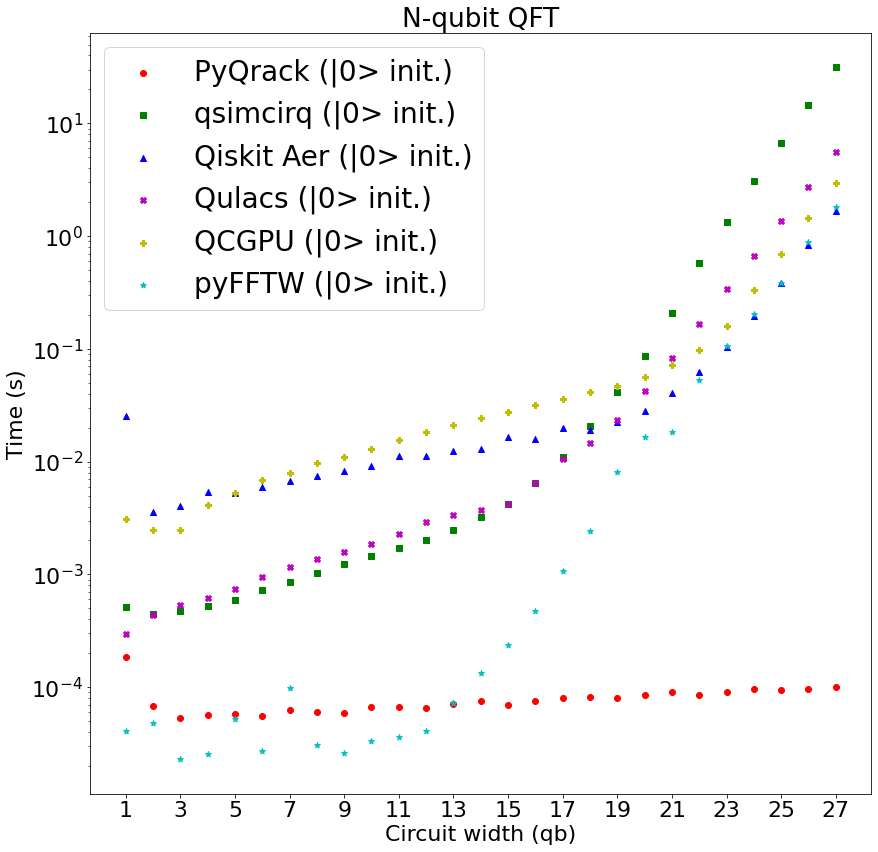

In [16]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.rc('legend',fontsize=28)
plt.rcParams.update({'font.size': 22})

colors = list("kcymbgr")
markers = list("D*PX^so")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = cuquantum_results.keys()
y = cuquantum_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = aer_results.keys()
y = aer_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qulacs_results.keys()
y = qulacs_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qcgpu_results.keys()
y = qcgpu_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_0_results.keys()
y = fftw_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

plt.title("N-qubit QFT")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack (|0> init.)", "qsimcirq (|0> init.)", "Qiskit Aer (|0> init.)", "Qulacs (|0> init.)", "QCGPU (|0> init.)", "pyFFTW (|0> init.)"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=2))

plt.show()

fig.savefig('qft_0_chart.png', dpi=100)

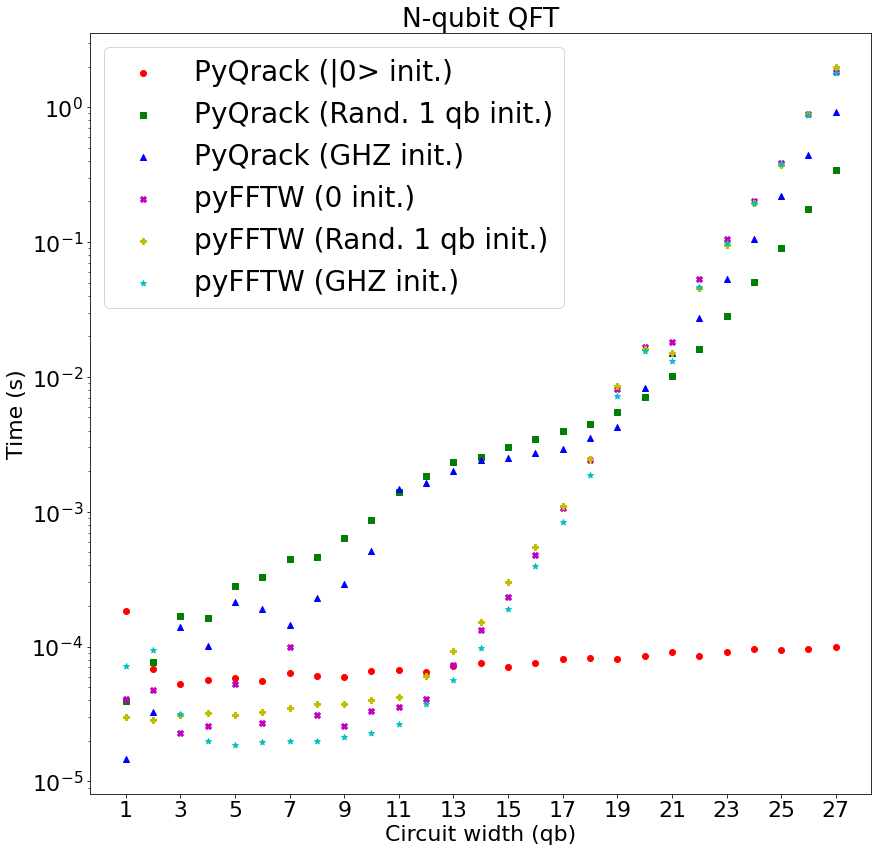

In [17]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.rc('legend',fontsize=28)
plt.rcParams.update({'font.size': 22})

colors = list("cymbgr")
markers = list("*PX^so")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qrack_results.keys()
y = qrack_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qrack_k_results.keys()
y = qrack_k_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_0_results.keys()
y = fftw_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_results.keys()
y = fftw_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_k_results.keys()
y = fftw_k_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

plt.title("N-qubit QFT")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack (|0> init.)", "PyQrack (Rand. 1 qb init.)", "PyQrack (GHZ init.)", "pyFFTW (0 init.)", "pyFFTW (Rand. 1 qb init.)", "pyFFTW (GHZ init.)"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=2))

plt.show()

fig.savefig('qft_ghz_chart.png', dpi=100)

In [18]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#36~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Feb 17 15:17:25 UTC 2
Linux-5.19.0-35-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='5.19.0-35-generic', version='#36~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Feb 17 15:17:25 UTC 2', machine='x86_64')
Linux
x86_64


In [19]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [20]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz'